# Deep Neural Network for Image Classification: Application II

- Build and apply a deep neural network to supervised learning.
- N Layer NN

In [424]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

from tools.activation_function import sigmoid, sigmoid_derivative, ReLU, ReLU_derivative, tanh, tanh_derivative

%matplotlib inline
np.random.seed(1)

In [425]:
# Loading the data
def load_dataset():  
    train_dataset = h5py.File('data/train_catvnoncat.h5', "r")
    # 209 samples, 64 * 64 pixels
    train_X = np.array(train_dataset["train_set_x"][:]) # (209, 64, 64, 3) 
    train_y = np.array(train_dataset["train_set_y"][:]) # (209,)
  
    test_dataset = h5py.File('data/test_catvnoncat.h5', "r")  
    # 50 samples
    test_X = np.array(test_dataset["test_set_x"][:]) # (50, 64, 64, 3)
    test_y = np.array(test_dataset["test_set_y"][:]) # (50,)
  
    # label
    classes = np.array(test_dataset["list_classes"][:]) # [b'non-cat' b'cat'] 
    
    # y = [...] => y = [[...]]
    train_y = np.array([train_y]) # train_y = train_y.reshape((1, train_y.shape[0]))
    test_y = np.array([test_y]) # test_y = test_y.reshape((1, test_y.shape[0])) 
    
    return train_X, train_y, test_X, test_y, classes

train_X, train_y, test_X, test_y, classes = load_dataset()

In [426]:
# Explore ur dataset

# print(train_X.shape) # (209, 64, 64, 3)
# print(train_y.shape) # (1, 209)

# the number of training samples
m_train = train_y.shape[1] # 209

# the number of test samples
m_test = test_y.shape[1] # 50

# size of image 64 * 64 * 3
num_px = train_X.shape[1: 4] # (64, 64, 3)

def handle_data ():
    # train_X: (209, 64, 64, 3) => (209, 64 * 64 * 3) => (64 * 64 * 3, 209)
    X_train_flatten = train_X.reshape(m_train, -1).T
    X_test_flatten = test_X.reshape(m_test, -1).T
    
    # Standardize data to have feature values between 0 and 1.
    X_train_flatten = X_train_flatten / 255
    X_test_flatten = X_test_flatten / 255

    return X_train_flatten, X_test_flatten

X_train_flatten, X_test_flatten = handle_data()
# print(X_train_flatten.shape) # (12288, 209)
# print(X_test_flatten.shape) # (12288, 50)

# 1. N - Layer Deep NN

In [464]:
class DeepNN ():
    def __init__ (self, Layers, X, y, hyperparams):
        # 层级
        self.Layers = Layers
        # 有几层
        self.L_num = len(Layers)
        # 样本数量 209
        self.m = y.shape[1]
        
        # parameters
        self.params = self.init_parameters()
        
        # hyperparameters
        """
        self.hyperparams = {
            'alpha': 0.01,
            'interations': 1000
        }
        """
        self.hyperparams = hyperparams

        # others:
        self.J = 0
        self.y = y
        self.A = { 'A0': X }
        self.dJ = {}

    def init_parameters (self):
        # 初始化 weights & bias
        params = {}
        for i in range(1, self.L_num):
            prev_L, next_L = self.Layers[i - 1], self.Layers[i]
            params['W' + str(i)] = np.random.randn(prev_L, next_L) * 0.01
            params['b' + str(i)] = np.zeros(shape = (next_L, 1))
        return params
    
    def forward_propagation (self):
        # step I: forward propagation
        for i in range(1, self.L_num):
            W, b = self.params['W' + str(i)], self.params['b' + str(i)]
            A_prev = self.A['A' + str(i - 1)]
            Z = np.dot(W.T, A_prev) + b
            A = ReLU(Z)

            if ((i == self.L_num - 1) and self.Layers[i] == 1):
                A = sigmoid(Z)

            self.A['A' + str(i)] = A
            
    def cost_function (self):
        # step II: cost function
        A = self.A['A' + str(self.L_num - 1)]
        y, m = self.y, self.m
        loss = -y * np.log(A) - (1 - y) * np.log(1 - A) 
        self.J = (1 / m) * np.sum(loss)

        self.J = np.squeeze(self.J)
        
    def get_dJ_dZ (self, i):
        A = self.A['A' + str(i)]
        # dJ_dZ = dJ_dZ_next * dZ_next_dA * dA_dZ_prev
        dJ_dZ_next = self.dJ['dJ_dZ' + str(i + 1)] # 上一层导数 (1, 209)
        # dZ_next_dA = self.params['W' + str(i + 1)] # 上一层W(3, 1)
        W_next = self.params['W' + str(i + 1)] # 上一层W(3, 1)
        dA_dZ_prev = ReLU_derivative(A) # 本层导数(3, 209)

        return np.dot(W_next, dJ_dZ_next) * dA_dZ_prev
        
    def get_dJ_dW_db (self, A_prev, dJ_dZ):
        m = self.m
        dJ_dW = (1 / m) * np.dot(A_prev, dJ_dZ.T)
        dJ_db = (1 / m) * np.sum(dJ_dZ, axis = 1, keepdims = True)
        
        return dJ_dW, dJ_db

    def backward_propagation (self):
        # step III: backward propagation
        parameters = self.params
        A = self.A
        # ===== Last Layer =====
        i_last = self.L_num - 1
        A_last, A_last_prev = A['A' + str(i_last)], A['A' + str(i_last - 1)]
        
        dJ_dZ_last = A_last - self.y # (1, 209)
        dJ_dW, dJ_db = self.get_dJ_dW_db(A_last_prev, dJ_dZ_last)
        
        self.dJ['dJ_dZ' + str(i_last)] = dJ_dZ_last
        self.dJ['dJ_dW' + str(i_last)] = dJ_dW
        self.dJ['dJ_db' + str(i_last)] = dJ_db
        
        # ===== Layer =====
        for i in reversed(range(1, self.L_num - 1)):
            dJ_dZ = self.get_dJ_dZ(i)
            dJ_dW, dJ_db = self.get_dJ_dW_db(A['A' + str(i - 1)], dJ_dZ)

            self.dJ['dJ_dZ' + str(i)] = dJ_dZ
            self.dJ['dJ_dW' + str(i)] = dJ_dW
            self.dJ['dJ_db' + str(i)] = dJ_db
        
        
    def gradient_descent (self):
        # step IV: gradient descent
        alpha = self.hyperparams['alpha']
        for i in reversed(range(1, self.L_num)):
            self.params['W' + str(i)] -= alpha * self.dJ['dJ_dW' + str(i)]
            self.params['b' + str(i)] -= alpha * self.dJ['dJ_db' + str(i)]

    def plot_J (self, J_arr):
        plt.plot(np.squeeze(J_arr))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(self.hyperparams['alpha']))
        plt.show()    
    
    def train (self):
        J_arr = []
        for i in range(self.hyperparams['interations']):
            self.forward_propagation()
            self.cost_function()
            if (i % 100 == 0):
                J_arr.append(self.J)

            self.backward_propagation()
            self.gradient_descent()
        
        self.cost_function()
        print('===代价函数===', self.J)
        print('===参数===', self.params)
        self.plot_J(J_arr)
        
    def predict (self):
        self.forward_propagation()
        A = self.A['A' + str(self.L_num - 1)]
        predictions = np.round(A)
        
        m = self.m
        print(predictions)
        accuracy = (1 - (1 / m) * np.sum(abs(predictions - self.y))) * 100
        print('训练精确度: ', accuracy)
        

===代价函数=== 0.0012962250019970063
===参数=== {'W1': array([[ 0.01772871, -0.00687661, -0.02882679, ..., -0.01259968,
        -0.01484584,  0.00057317],
       [ 0.00510682,  0.01147076,  0.01380223, ..., -0.00515792,
         0.0290835 ,  0.00342089],
       [ 0.00202754,  0.00156996, -0.00205799, ...,  0.00078504,
        -0.00809558,  0.00110015],
       ...,
       [ 0.01001132, -0.00147675,  0.00571786, ...,  0.00459443,
        -0.00228987, -0.01688451],
       [ 0.01389459, -0.00789715,  0.02464457, ...,  0.00230924,
         0.0037668 ,  0.00374302],
       [ 0.01120898, -0.01560445, -0.01637004, ..., -0.00437097,
        -0.00769108, -0.01132595]]), 'b1': array([[ 4.65718915e-02],
       [-5.95663023e-03],
       [ 4.68678033e-02],
       [ 5.55447860e-03],
       [-1.09197542e-05],
       [-1.32020652e-02],
       [ 1.53508675e-02],
       [-2.07708394e-02],
       [ 6.50420315e-03],
       [ 2.29153889e-02],
       [ 9.72752872e-03],
       [-3.89129112e-02],
       [ 1.58105262

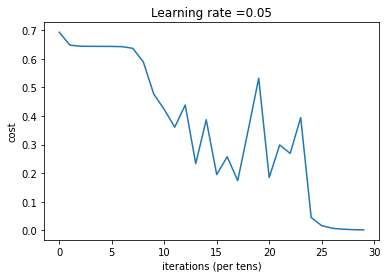

[[0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1.
  0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0.
  0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0.
  1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0.
  0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
  1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
训练精确度:  100.0


"\nLayers = np.array([input_layer_num, 20, 10, 1])\nhyperparams = { 'alpha': 0.05, 'interations': 1000 }\n"

In [465]:
# 初始化层级处理
input_layer_num = X_train_flatten.shape[0]
Layers = np.array([input_layer_num, 20, 10, 1])

# 对象
hyperparams = { 'alpha': 0.05, 'interations': 3000 }
NN = DeepNN(Layers, X_train_flatten, train_y, hyperparams)
NN.train()

NN.predict()
"""
Layers = np.array([input_layer_num, 20, 10, 1])
hyperparams = { 'alpha': 0.05, 'interations': 1000 }
"""

===代价函数=== 0.16793436664257622
===参数=== {'W1': array([[-0.00719319, -0.01398527, -0.00164501, ..., -0.00347807,
         0.04449182, -0.01831435],
       [ 0.01429932,  0.01292372,  0.00440381, ..., -0.02320086,
         0.00641088, -0.01065809],
       [-0.00628619,  0.02762785,  0.01106437, ..., -0.00349314,
         0.00748449, -0.01559461],
       ...,
       [-0.03382941,  0.00805639, -0.00228511, ..., -0.0096911 ,
         0.01233765, -0.01834534],
       [ 0.00326149,  0.01934954, -0.004989  , ..., -0.02054562,
         0.01732948, -0.02468859],
       [-0.00139112, -0.00404633, -0.00254343, ..., -0.02063528,
         0.01529798, -0.01942186]]), 'b1': array([[ 0.00356971],
       [-0.01698432],
       [ 0.0168191 ],
       [ 0.0171464 ],
       [ 0.01372625],
       [ 0.03003073],
       [ 0.03132478],
       [ 0.00429232],
       [ 0.03503827],
       [ 0.01377704]]), 'W2': array([[-0.35976048],
       [-0.60292889],
       [-0.48713541],
       [-0.72359197],
       [-0.603094

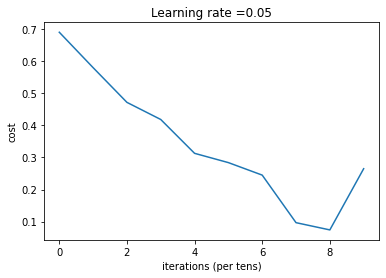

In [466]:
# 初始化层级处理
input_layer_num = X_train_flatten.shape[0]
Layers = np.array([input_layer_num, 10, 1])

# 对象
hyperparams = { 'alpha': 0.05, 'interations': 1000 }
NN = DeepNN(Layers, X_train_flatten, train_y, hyperparams)
NN.train()